In [1]:
import os
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import plotly.express as px
import pandas as pd
import os
import seaborn as sns
import webbrowser

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse

In [2]:
def get_arr(Arr):
    filtered_arrays = [arr[:, :1500] for arr in Arr]
    concatenated_array = np.concatenate(filtered_arrays, axis=0)
    print(concatenated_array.shape)
    return concatenated_array

In [3]:
files = [i for i in os.listdir('./male') if i.endswith('.mat')]
files_lab = [i.split(' ') for i in files]
label = []
for i in files_lab:
    if (('hom' in i) or ('(hom)' in i)):
        label.append(1)
    else:
        label.append(0)

In [4]:
np.unique(label,return_counts=True)

(array([0, 1]), array([ 9, 13]))

In [5]:
male_control = []
male_mutant = []
for i,ele in enumerate(files):
    mat = scipy.io.loadmat('./male/'+ele)
    if label[i]==0:
        male_control.append(mat['corrTRACE'].T)
    else:
        male_mutant.append(mat['corrTRACE'].T)
        
male_control = np.concatenate(male_control, axis=0)
male_mutant = np.concatenate(male_mutant, axis=0)

male_control = np.array(male_control)
male_mutant = np.array(male_mutant)

In [6]:
def plot_stats(x, data, subplot_index, label, color, a = 1,b = 2):
    mean_val = np.mean(data, axis=0)
    std_val = np.std(data, axis=0)    
    plt.subplot(a, b, subplot_index)
    plt.plot(x, mean_val, color=color, label=label, linewidth=2)
    plt.fill_between(x, mean_val - std_val, mean_val + std_val, color=color, alpha=0.3)
    plt.ylim([-0.5, 1.2])
    plt.xlabel('Time',  fontsize=12)
    plt.ylabel(r'$\Delta F / F_0$',  fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize =12)

In [7]:
plt.style.use('seaborn-v0_8-darkgrid')

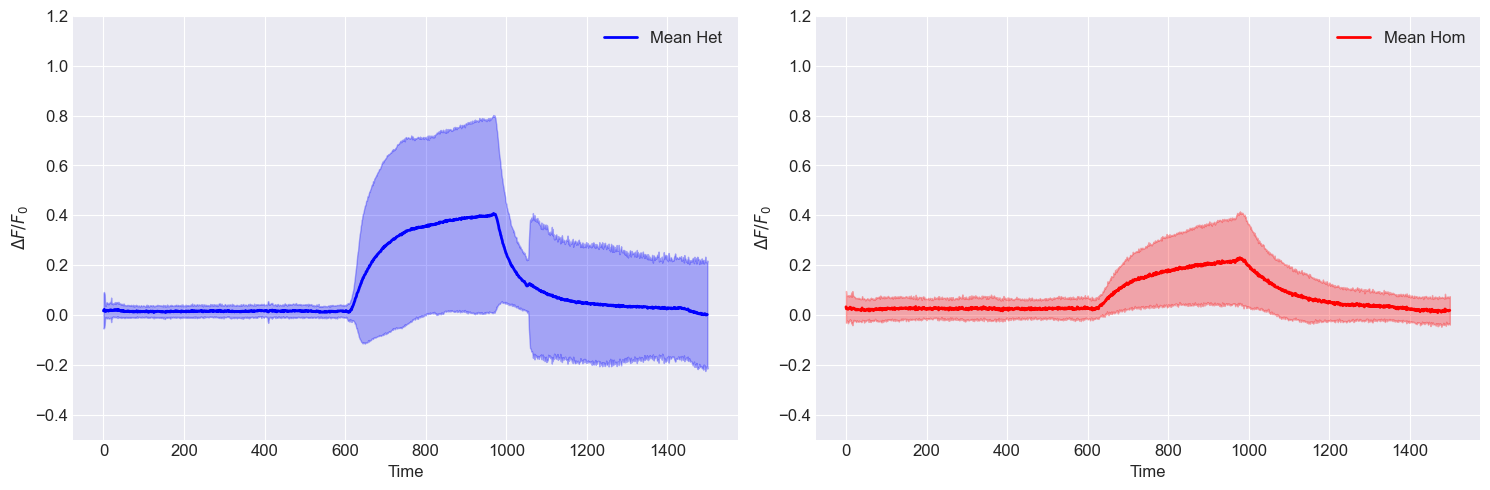

In [8]:
plt.figure(figsize=(15, 5))
x = np.arange(male_control.shape[1])

plot_stats(x, male_control, 1, 'Mean Het', 'blue')
plot_stats(x, male_mutant, 2,  'Mean Hom', 'red')

plt.tight_layout()
plt.show()

In [9]:
np.max(np.mean(male_control,axis = 0)),np.max(np.mean(male_mutant,axis = 0))

(0.40725078261066744, 0.23000479777774593)

In [10]:
def plot_stats_2(x, data1, data2, label1, label2, color1, color2, a=1, b=2):
    mean_val1 = np.mean(data1, axis=0)
    mean_val2 = np.mean(data2, axis=0)    
    
    plt.plot(x, mean_val1, color=color1, label=label1, linewidth=2)    
    plt.plot(x, mean_val2, color=color2, label=label2, linewidth=2)
    
    plt.ylim([-0.5, 1.2])
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(r'$\Delta F / F_0$',  fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)

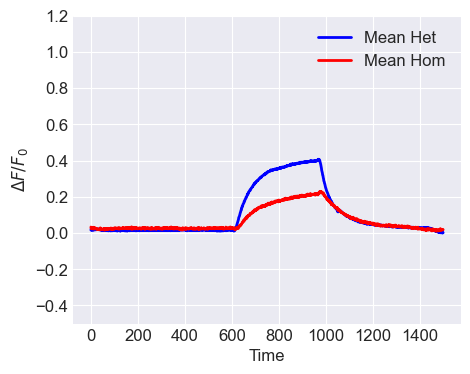

In [11]:
plt.figure(figsize=(5,4))

plot_stats_2(x, male_control, male_mutant,  'Mean Het', 'Mean Hom', 'blue','red')
plt.show()

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')

In [22]:
def plot_2d(x, labels):
    x_filtered = np.array(x)
    labels_filtered = np.array(labels)

    control_transform = x_filtered[labels_filtered == 0]
    mutant_transform = x_filtered[labels_filtered == 1]

    plt.scatter(control_transform[:, 0], control_transform[:, 1],
                label='Het', color='blue', alpha=0.7, edgecolors='k', s=30)
    plt.scatter(mutant_transform[:, 0], mutant_transform[:, 1],
                label='Hom', color='red', alpha=0.7, edgecolors='k', s=30)
   
    plt.xlabel('Feature 1',fontsize=12)
    plt.ylabel('Feature 2',fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
    plt.legend()
    plt.grid(True)

In [23]:
def remove_outliers(data, threshold=1.5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask], mask

In [24]:
label_total = np.vstack([np.tile(0, (male_control.shape[0], 1)),np.tile(1, (male_mutant.shape[0], 1))])
label_total_male = label_total.flatten()

data_total_male = np.vstack([male_control, male_mutant ])

In [25]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
data_2d = tsne.fit_transform(data_total_male)

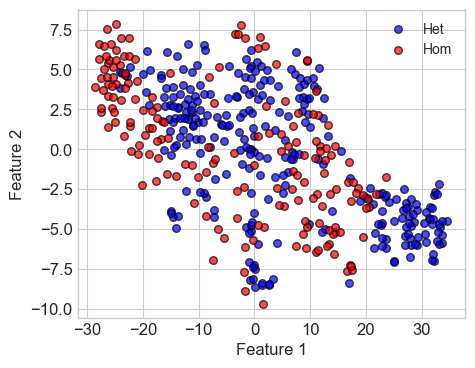

In [26]:
plt.figure(figsize=(5,4))

plot_2d(data_2d,label_total_male)
plt.show()

In [27]:
def get_clusters(data, true_labels, BK=2):
    range_K = range(2, 7)
    best_K = []
    best_score = []
    best_labels = []
    best_kmeans = []

    for K in range_K:
        kmeans = KMeans(n_clusters=K, n_init=10, random_state=42).fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        print(f"Results for K={K}, Silhouette Score: {score:.3f}")

        # Plot scatter of the clustering result using the first two features
        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', edgecolor='k')
        plt.title(f"KMeans Clustering (K={K})")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

        # Build a DataFrame to compare k-means clusters with the true labels
        df = pd.DataFrame({'Cluster': labels, 'True Label': true_labels})
        cluster_composition = df.groupby(['Cluster', 'True Label']).size().unstack(fill_value=0)
        
        # For only 2 true classes (0 and 1)
        cluster_composition['Total Size'] = cluster_composition.get(0, 0) + cluster_composition.get(1, 0)
        cluster_composition['C0'] = cluster_composition.get(0, 0) / cluster_composition['Total Size']
        cluster_composition['C1'] = cluster_composition.get(1, 0) / cluster_composition['Total Size']
        print(cluster_composition[['Total Size', 'C0', 'C1']], "\n")

        best_K.append(K)
        best_score.append(score)
        best_labels.append(labels)
        best_kmeans.append(kmeans)
    
    print([np.shape(i) for i in [best_K, best_score, best_labels, best_kmeans]])
    return best_K[BK], best_score[BK], best_labels[BK], best_kmeans[BK]

Results for K=2, Silhouette Score: 0.539


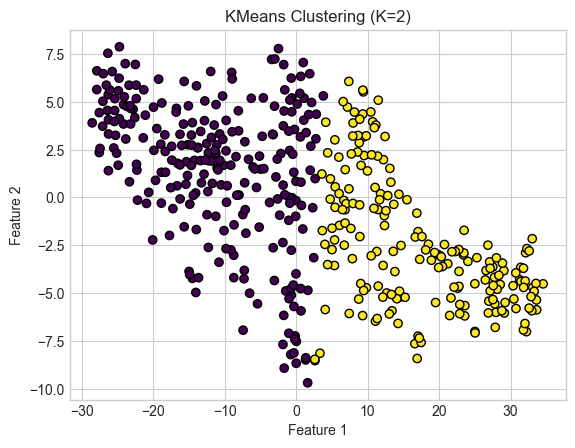

True Label  Total Size        C0        C1
Cluster                                   
0                  259  0.590734  0.409266
1                  195  0.646154  0.353846 

Results for K=3, Silhouette Score: 0.536


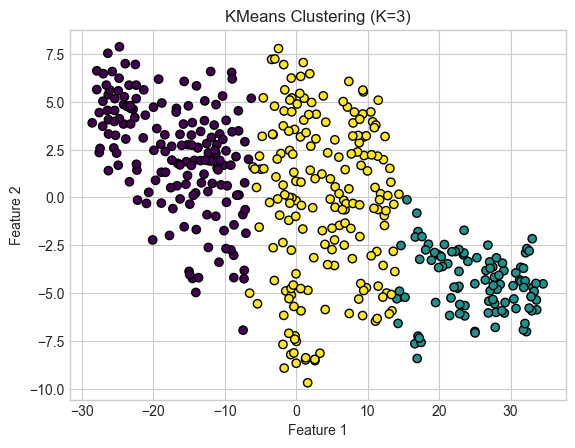

True Label  Total Size        C0        C1
Cluster                                   
0                  165  0.509091  0.490909
1                  100  0.770000  0.230000
2                  189  0.624339  0.375661 

Results for K=4, Silhouette Score: 0.478


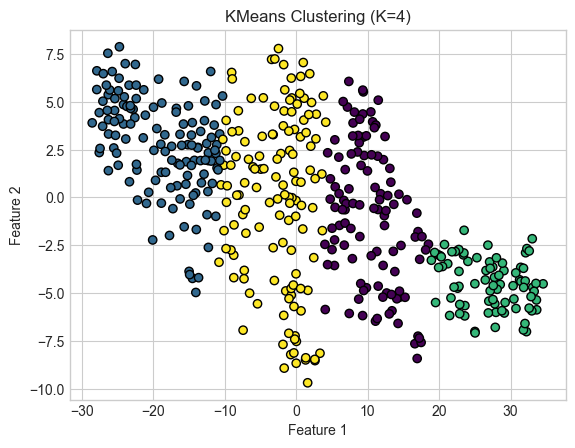

True Label  Total Size        C0        C1
Cluster                                   
0                  108  0.425926  0.574074
1                  132  0.469697  0.530303
2                   81  0.913580  0.086420
3                  133  0.729323  0.270677 

Results for K=5, Silhouette Score: 0.474


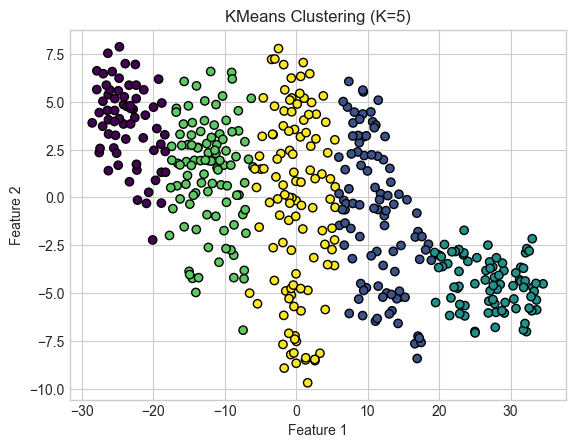

True Label  Total Size        C0        C1
Cluster                                   
0                   66  0.151515  0.848485
1                   96  0.416667  0.583333
2                   80  0.912500  0.087500
3                  100  0.750000  0.250000
4                  112  0.723214  0.276786 

Results for K=6, Silhouette Score: 0.454


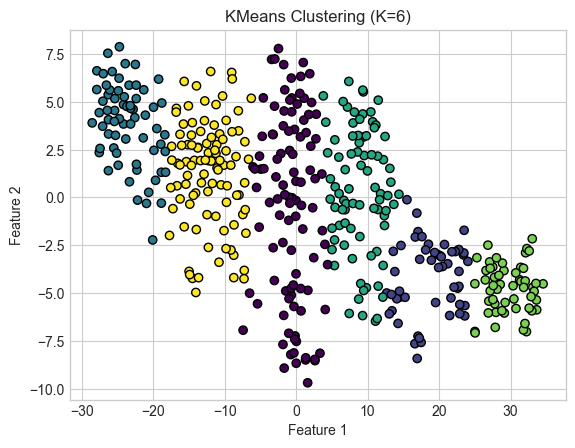

True Label  Total Size        C0        C1
Cluster                                   
0                  102  0.735294  0.264706
1                   52  0.480769  0.519231
2                   66  0.151515  0.848485
3                   82  0.500000  0.500000
4                   54  1.000000  0.000000
5                   98  0.755102  0.244898 

[(5,), (5,), (5, 454), (5,)]


In [28]:
best_K, best_score, best_labels, best_kmeans = get_clusters(data_2d,label_total_male,BK = 4)


In [29]:
def remove_outliers(data, threshold=1.5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    mask = np.all((data >= lower_bound) & (data <= upper_bound), axis=1)
    return data[mask], mask

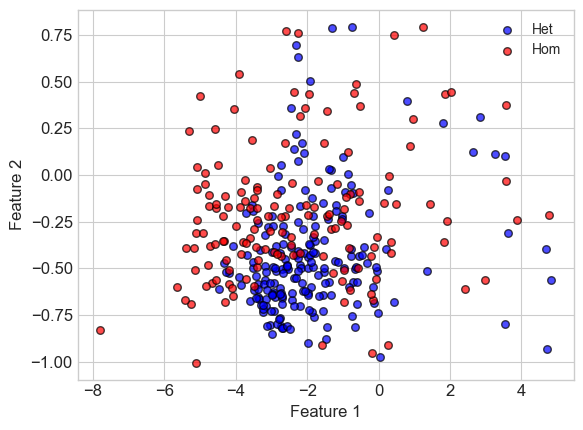

In [30]:
pca = PCA(n_components=2)


pca.fit(data_total_male)
X_total_pca = pca.transform(data_total_male)
x_filtered, mask = remove_outliers(X_total_pca)
labels_filtered = np.array(label_total_male)[mask]    
plot_2d(x_filtered, labels_filtered)


In [31]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 2)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(2, output_size)  
        self.sigmoid = nn.Sigmoid() 
        
    def forward(self, x):
        x1 = self.fc1(x)      
        x = self.relu(x1)    
        x = self.fc2(x)      
        return x1, x        

class SimpleNN_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN_2, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)  
        self.sigmoid = nn.Sigmoid() 
        
    def forward(self, x):
        x1 = self.fc1(x)      
        x = self.relu(x1)    
        x = self.fc2(x)      
        return x1, x        


In [32]:
def prep_data(data,labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels,test_size=0.2,random_state=42,stratify=labels)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [33]:
def test_all(data = data_total_male, label = label_total_male):
    X_tot = torch.tensor(data, dtype=torch.float32)
    y_tot = torch.tensor(label, dtype=torch.long)

    tot_dataset = TensorDataset(X_tot, y_tot)
    tot_loader = DataLoader(tot_dataset, batch_size=32, shuffle=False)
    return tot_loader

In [34]:
def extract_nn_features(loader, model):
    model.eval()
    all_nn_features = []
    all_labels = []
    with torch.no_grad():
        for batch_data, batch_labels in loader:
            features, _ = model(batch_data)
            all_nn_features.append(features.numpy())
            all_labels.append(batch_labels.numpy())
    nn_features_array = np.concatenate(all_nn_features, axis=0)
    labels_array = np.concatenate(all_labels, axis=0)
    return labels_array, nn_features_array

In [35]:
def plotter(data_2d, labels_array, image_name, folder_name='./'):
    x_min, x_max = np.min(data_2d[:, 0]), np.max(data_2d[:, 0])
    bin_width = (x_max - x_min) / 7
    x_intervals = np.linspace(x_min, x_max, 8)  # Ensure exactly 7 bins
    
    colors = ['red', 'green', 'blue']
    fig, ax = plt.subplots(figsize=(10, 6))

    control_transform = data_2d[labels_array == 0]
    treated_mutant_transform = data_2d[labels_array == 1]
    mutant_transform = data_2d[labels_array == 2]

    plt.scatter(control_transform[:, 0], control_transform[:, 1],label='Het', color='blue', alpha=0.8,edgecolors='k')
    plt.scatter(mutant_transform[:, 0], mutant_transform[:, 1],label='Hom', color='red', alpha=0.8,edgecolors='k')
    plt.scatter(treated_mutant_transform[:, 0], treated_mutant_transform[:, 1],label='Hom + LHR-Chap', color='green', alpha=0.8,edgecolors='k')
    
    for x in x_intervals:
        ax.axvline(x, color='gray', linestyle='--', alpha=0.7)
    
    # Adjust y limits dynamically
    y_min, y_max = np.min(data_2d[:, 1]), np.max(data_2d[:, 1])
    ax.set_ylim(y_min - ((y_max - y_min) * 0.2), y_max + (y_max - y_min) * 0.2)
    
    for i in range(len(x_intervals) - 1):
        x_start, x_end = x_intervals[i], x_intervals[i + 1]
        if i == len(x_intervals) - 2:
            mask = (data_2d[:, 0] >= x_start) & (data_2d[:, 0] <= x_end)  # Include the last bin
        else:
            mask = (data_2d[:, 0] >= x_start) & (data_2d[:, 0] < x_end)
        counts = np.bincount(labels_array[mask], minlength=3)  # Count occurrences of labels 0,1,2
        text_x = (x_start + x_end) / 2  # Midpoint of the interval
        text_y = y_max + (y_max - y_min) * 0.1  # Position much above the plot
        ax.text(text_x, text_y, f"{counts[0]},{counts[1]},{counts[2]}",
                ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    # ax.set_title("Scatter Plot")
    plt.legend(loc='lower left')

    plt.show()

In [36]:
def model_train(model,train_loader,test_loader):
    num_epochs = 10000
    Net_acc = [0.0]
    Net_loss = [np.inf]
    epochs_since_improvement = 0
    patience = 30
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            _,outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        if epoch%50 == 0:
            model.eval()
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    _,outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(labels.cpu().numpy())
            accuracy = accuracy_score(np.array(all_targets), np.array(all_preds))
            print (accuracy)
            if accuracy>np.max(Net_acc):
                epochs_since_improvement = 0
                torch.save(model.state_dict(), './male.pth')
                print ('Model saved')
            else:
                epochs_since_improvement += 1
    
            Net_acc.append(accuracy)
            Net_loss.append(loss.item())
            
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered. No improvement in the last {patience} evaluations.")
                break    
    #model.load_state_dict(torch.load('./male.pth'))
    return model

In [43]:
input_size = 1500
label                    = label_total_male
output_size              = len(np.unique(label))
model                    = SimpleNN_2(input_size, output_size)
tr_loader, tst_loader    = prep_data(data_total_male,label_total_male)
#model                    = model_train(model,tr_loader, tst_loader)
model.load_state_dict(torch.load('./models/male.pth'))
ts_loader                = test_all()
labels_array, features   = extract_nn_features(ts_loader,model) 
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
data_2d =  tsne.fit_transform(features)

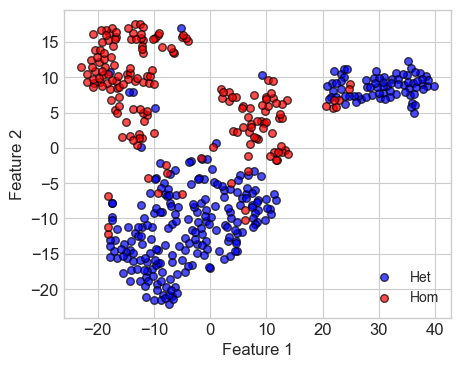

In [104]:
plt.figure(figsize=(5,4))

plot_2d(data_2d,label_total_male)
plt.show()



Results for K=2, Silhouette Score: 0.499
True Label  Total Size        C0        C1
Cluster                                   
0                  342  0.599415  0.400585
1                  112  0.660714  0.339286 

Results for K=3, Silhouette Score: 0.541
True Label  Total Size        C0        C1
Cluster                                   
0                  113  0.053097  0.946903
1                  123  0.601626  0.398374
2                  218  0.912844  0.087156 

Results for K=4, Silhouette Score: 0.557
True Label  Total Size        C0        C1
Cluster                                   
0                  145  0.944828  0.055172
1                   80  0.912500  0.087500
2                  122  0.516393  0.483607
3                  107  0.056075  0.943925 

Results for K=5, Silhouette Score: 0.530
True Label  Total Size        C0        C1
Cluster                                   
0                  107  0.056075  0.943925
1                   58  0.068966  0.931034
2            

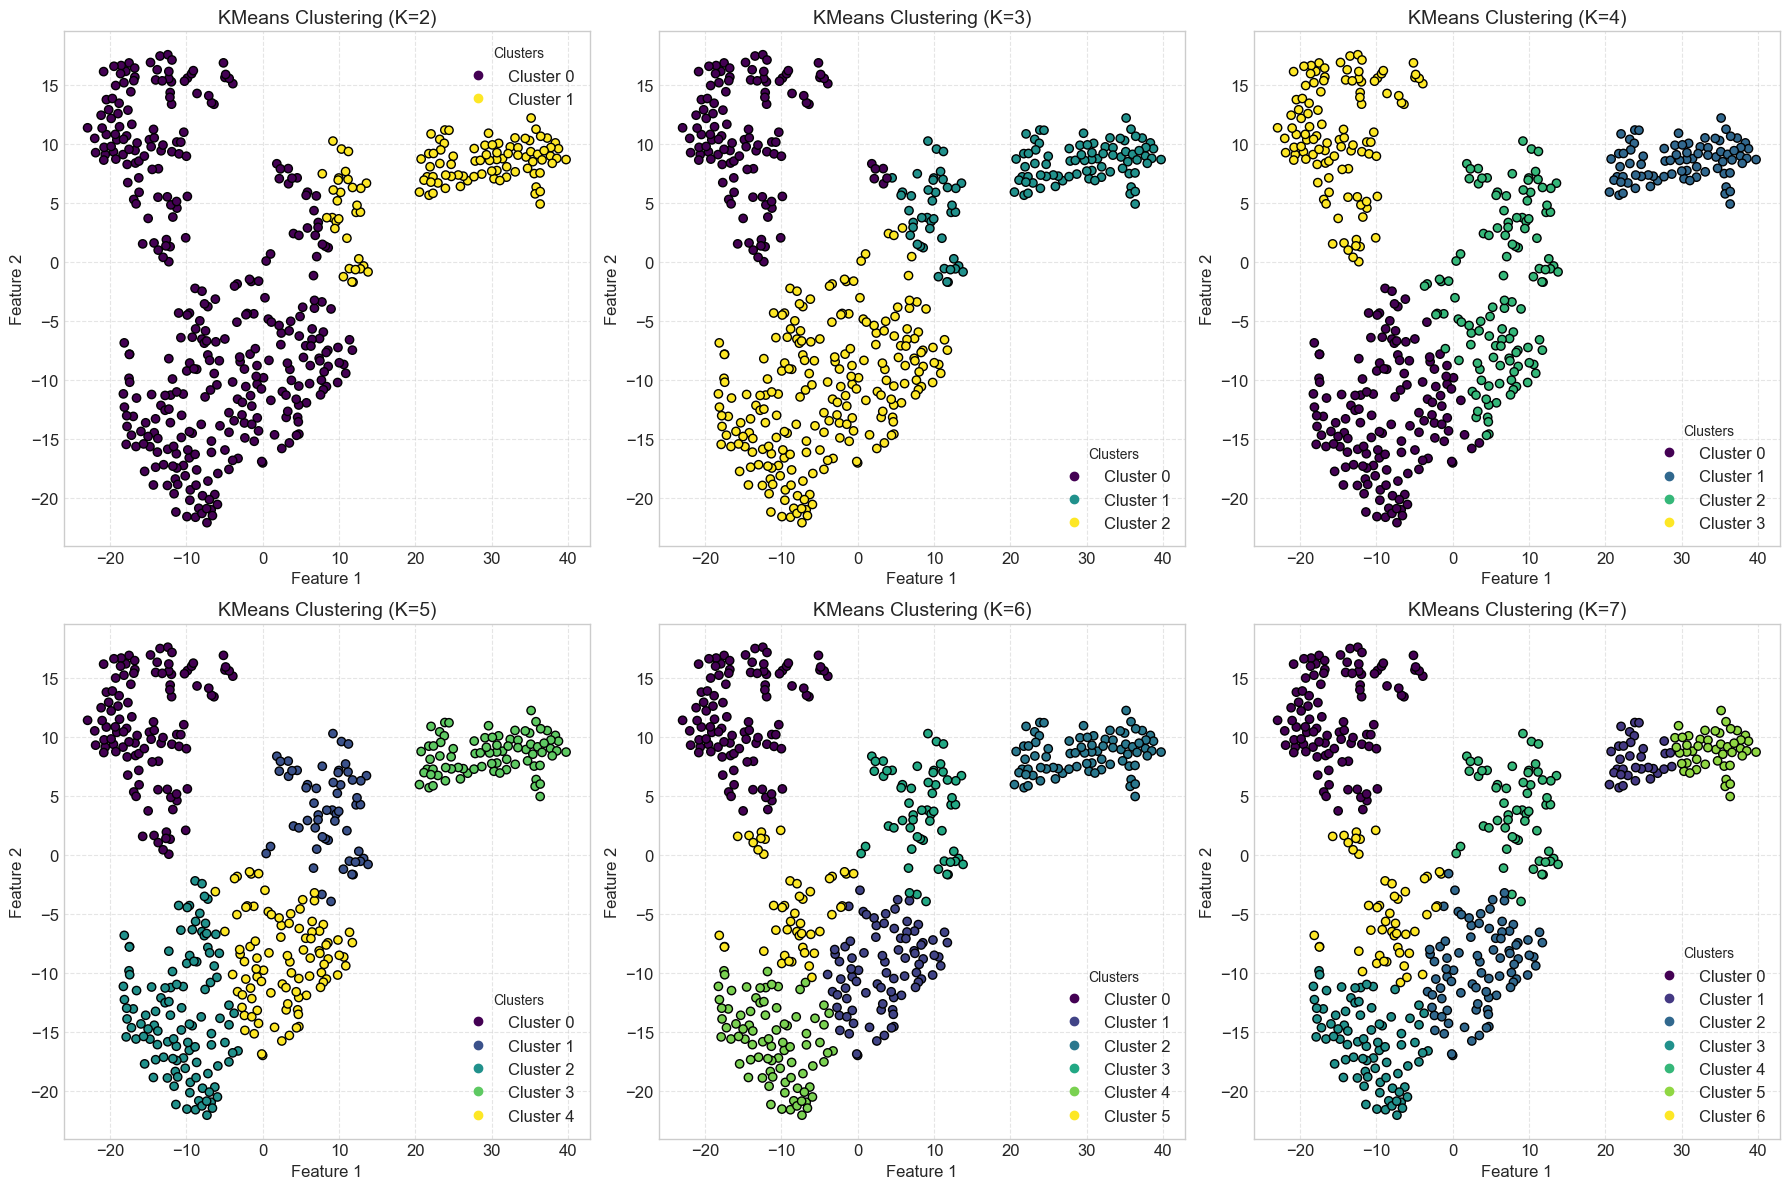

In [108]:
best_K, best_score, best_labels, best_kmeans = get_clusters(data_2d,label_total_male,BK = 4)


In [ ]:
# best_K, best_score, best_labels, best_kmeans = get_clusters(data_2d,label_total)
# plot_clusters_with_std(data_2d, best_kmeans,label_total)